# Cryptocurrency Model building

*Mohammed Jamil*

## Context

The first half of 2022 has been very bad for the crypto market. Crypto industry experts have mixed opinions about the future of cryptocurrencies. While some believe the market will continue to be volatile, others expect some stability in the second half of 2022.

In these uncertain times for the crypto market, is it still worth the risk investing in cryptocurrencies ? and what are the low-risk cryptocurrencies to consider ?

## Table of Contents :

- Importing data
- Data Preparation
- Model Building

## Dependencies :

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
%matplotlib inline

plt.style.use('ggplot')

---

### Importing Data :

In the previous notebook (Crypto market analysis) we took a look at the tendencies of the crypto market to find out what are the top 10 cryptocurrencies currently, and exported the historical daily prices data into a csv file. Firstly, Let's start by loading the data.

NB: If you are not using bash make sure to comment the next cell and run the previous notebook.

In [4]:
%%bash

CSV_FILE=./top10-crypto-daily-prices.csv

if [ ! -f "$CSV_FILE" ]; then
    python3 crypto-daily-prices.py
fi

In [5]:
# Reading data from csv.

file = "top10-crypto-daily-prices.csv"
daily_prices_df = pd.read_csv(file, index_col=0)
daily_prices_df.date = pd.to_datetime(daily_prices_df.date)
print("DataFrame shape :",daily_prices_df.shape)
daily_prices_df.head()

DataFrame shape : (22387, 3)


,id,date,price
0,bitcoin,2013-04-28,135.30
1,bitcoin,2013-04-29,141.96
2,bitcoin,2013-04-30,135.30
3,bitcoin,2013-05-01,117.00
4,bitcoin,2013-05-02,103.43


Now that we imported the data let's print the top 10 currencies.

In [6]:
top10_crypto = list(daily_prices_df['id'].unique())
print("Top 10 cryptocurrencies:")
for coin in top10_crypto:
    print("\t",coin)

Top 10 cryptocurrencies:
	 bitcoin
	 ethereum
	 tether
	 usd-coin
	 binancecoin
	 binance-usd
	 ripple
	 cardano
	 solana
	 dogecoin


Let's visualize bitcoin price evolution to make sure that our date matches the previous lab results.

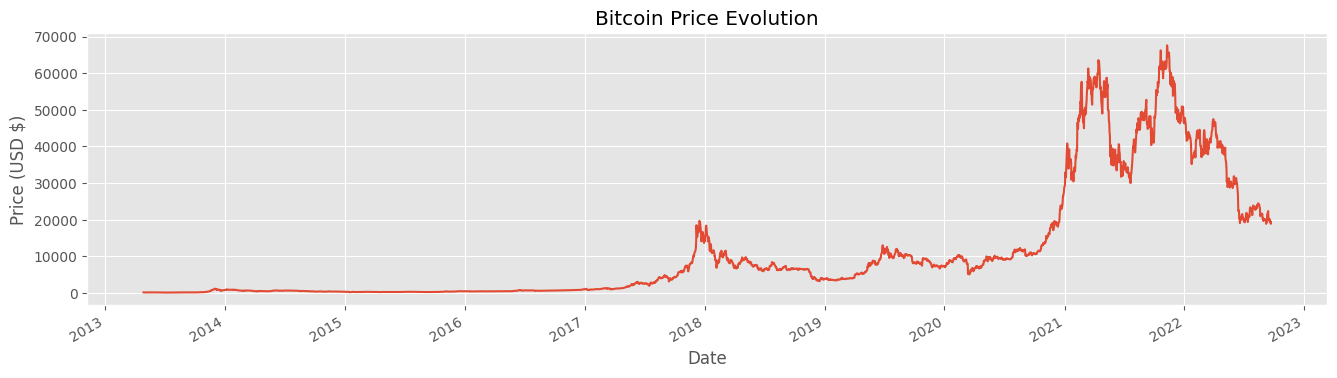

In [7]:
bitcoin_df = daily_prices_df[daily_prices_df['id'] == "bitcoin"].drop(columns=['id'])
bitcoin_df.plot(kind="line", x="date", y="price", figsize=(16, 4) , xlabel="Date", ylabel="Price (USD $)", title="Bitcoin Price Evolution", legend=False)
plt.show()

Perfect !

---

### Data Preparation :

Firstly, we should transform our dataframe into a dictionary of 10 arrays with scaled values, each array corresponding to a cryptocurrency.

In [8]:
top10_crypto_dict = {}

for coin in top10_crypto:
    top10_crypto_dict[coin] = daily_prices_df[daily_prices_df['id'] == coin]

We need to split our datasets into training and testing data.

In [9]:
# define global variables.

n_past = 14  #number of days to use to predict the future
scalers_dict = {}

# define spliting function

def train_test_split(coin, train_ratio):
    """
    Splits data into training and testing datasets.
    
    Params:
    -------
        coin (String)       - The cryptocurrency id.
        train_ratio (float) - The training dataset ratio.
    
    Return:
    -------
        x_train (np.array) - Training independent variables.
        y_train (np.array) - Training dependent variable.
        x_test (np.array)  - Testing independent variables.
        y_test (np.array)  - Testing dependent variable.
    """
    
    data = top10_crypto_dict[coin][["price"]].values
    train_len = int(len(data)*train_ratio)
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(data[0:train_len, :])
    test_data = scaler.transform(data[train_len - n_past:, :])
    scalers_dict[coin] = scaler
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for i in range(n_past, train_len):
        x_train.append(train_data[i - n_past:i, 0])
        y_train.append(train_data[i:i+1, 0])
        
    for i in range(n_past, len(test_data)):
        x_test.append(test_data[i - n_past:i, 0])
        y_test.append(test_data[i:i+1, 0])
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test

---

### Model Building :

Now everything is ready to build the predictive model, we are going to use LSTM provided by **Keras** for this purpose.

In [10]:
def predictive_model(coin):
    """
    Builds the predictive model for a given crypocurrency.
    
    Params:
    -------
        coin (String) - The cryptocurrency id.
    
    Returns:
    --------
        predictive model.
    """
    
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_past, 1), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(1))
    
    model.compile(optimizer="adam", loss="mse")
        
    return model

Let's build the bitcoin predictive model and test it.

In [12]:
train_ratio = 0.9
x_train, y_train, x_test, y_test = train_test_split('bitcoin', train_ratio)

bitcoin_model = predictive_model('bitcoin')
bitcoin_model.fit(x_train, y_train, epochs=8, batch_size=16)

y_pred = bitcoin_model.predict(x_test)

y_test = scalers_dict['bitcoin'].inverse_transform(y_test)
y_pred = scalers_dict['bitcoin'].inverse_transform(y_pred)

Epoch 1/8
193/193 [==============================] - 3s 7ms/step - loss: 0.0060
Epoch 2/8
193/193 [==============================] - 1s 7ms/step - loss: 6.0833e-04
Epoch 3/8
193/193 [==============================] - 2s 8ms/step - loss: 4.5415e-04
Epoch 4/8
193/193 [==============================] - 1s 7ms/step - loss: 4.3689e-04
Epoch 5/8
193/193 [==============================] - 1s 7ms/step - loss: 4.5464e-04
Epoch 6/8
193/193 [==============================] - 1s 7ms/step - loss: 3.9672e-04
Epoch 7/8
193/193 [==============================] - 1s 7ms/step - loss: 3.2420e-04
Epoch 8/8
11/11 [==============================] - 0s 3ms/step


Now let's plot the predictions.

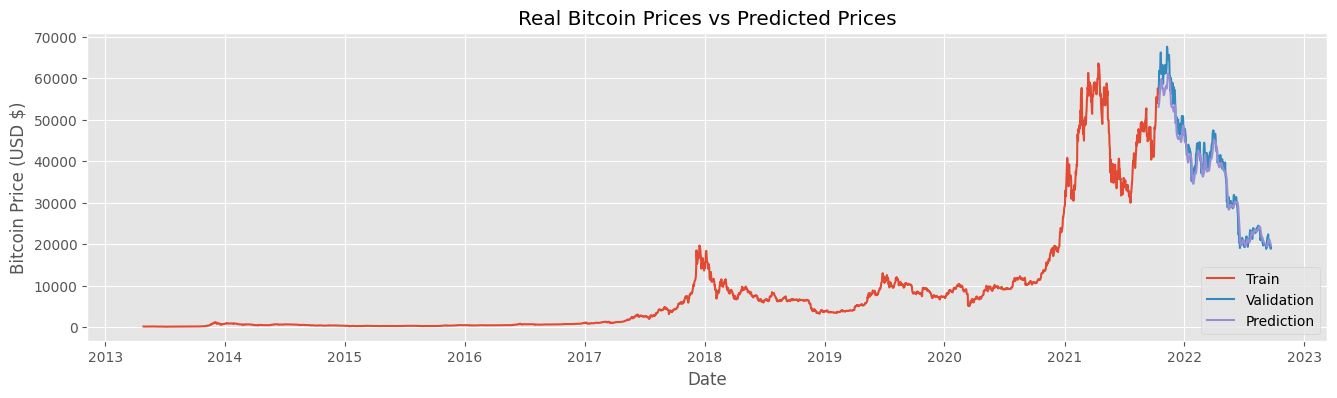

In [13]:
# Creating dfs

bitcoin_df = top10_crypto_dict['bitcoin']
train_len = int(bitcoin_df.shape[0]*train_ratio)
train_df = bitcoin_df[:train_len]
test_df = bitcoin_df[train_len:]
test_df.insert(2, "prediction", y_pred, True)

# Ploting results

plt.figure(figsize=(16, 4))
plt.plot(train_df['date'], train_df[['price']])
plt.plot(test_df['date'], test_df[['price', 'prediction']])
plt.legend(["Train", "Validation", "Prediction"], loc="lower right")
plt.title("Real Bitcoin Prices vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price (USD $)")
plt.show()

The model seems to be quite accurate on the bitcoin dataset.